# ALS Analysis

In [1]:
import pandas as pd
import numpy as np
from lenskit.algorithms.item_knn import ItemItem
%matplotlib inline

## Parameter Sweep

In [7]:
db_url = 'sqlite:///build/sweep-als-ml-100k.sqlite'

In [2]:
runs = pd.read_csv('build/sweep-als-ml-100k-runs.csv')
runs.head()

,Partition,PredictTime,TrainTime,features,regularization
0,0,0.272335,4.142731,5,0.01
1,0,0.266131,0.285256,5,0.05
2,0,0.298862,0.271214,5,0.10
3,0,0.270010,0.335574,10,0.01
4,0,0.274010,0.323200,10,0.05


In [3]:
preds = pd.read_csv('build/sweep-als-ml-100k-preds.csv')
preds.head()

,user,item,rating,timestamp,prediction,features,regularization
0,2,14,4,888551853,4.524923,5,0.01
1,2,111,4,888551853,3.614919,5,0.01
2,2,272,5,888979061,4.512429,5,0.01
3,2,19,3,888550871,4.641066,5,0.01
4,2,305,3,888550065,4.024135,5,0.01


In [5]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error * preds.error
mse = preds.groupby(['features', 'regularization']).sqerr.mean()
rmse = np.sqrt(mse)
rmse = rmse.reset_index(name='RMSE')
rmse.head()

,features,regularization,RMSE
0,5,0.01,1.037181
1,5,0.05,0.964668
2,5,0.10,0.940553
3,10,0.01,1.182058
4,10,0.05,0.988455


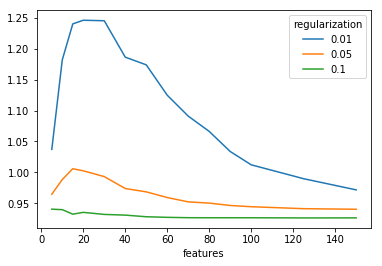

In [6]:
rmse_piv = rmse.pivot(index='features', columns='regularization', values='RMSE')
rmse_piv.plot()

## Training Study

In [20]:
epochs = pd.read_csv('build/probe-als-ml-10m.csv')

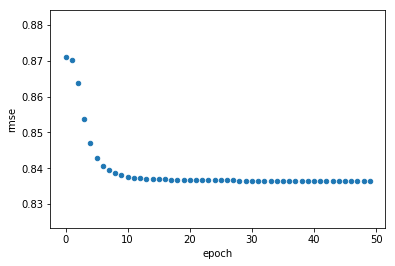

In [21]:
epochs.plot.scatter(x='epoch', y='rmse')